In [73]:
import os
import nibabel as nib
from nibabel.testing import data_path
import matplotlib
from nilearn import plotting, image
from nilearn.image import mean_img


In [56]:
# link to fMRI scan
input_fmri_file = "/Users/joachimpfefferkorn/Documents/mri_data/To_Share/MNI_Space/filtreg_sm_dspk_sk_sub-AG5_ses-baseline_task-Newresting1HB6scan_space-MNI152NLin2009cAsym_desc-preproc_bold.nii"

In [57]:
andrew_brain_filename = os.path.join(data_path, input_fmri_file)
andrew_brain_img = nib.load(andrew_brain_filename) #why is this a join?

In [58]:
print(andrew_brain_filename)

/Users/joachimpfefferkorn/Documents/mri_data/To_Share/MNI_Space/filtreg_sm_dspk_sk_sub-AG5_ses-baseline_task-Newresting1HB6scan_space-MNI152NLin2009cAsym_desc-preproc_bold.nii


/Users/joachimpfefferkorn/repos/neurovolume/.venv/lib/python3.11/site-packages/numpy/_core/fromnumeric.py:820: UserWarning: Warning: 'partition' will ignore the 'mask' of the MaskedArray.
  a.partition(kth, axis=axis, kind=kind, order=order)



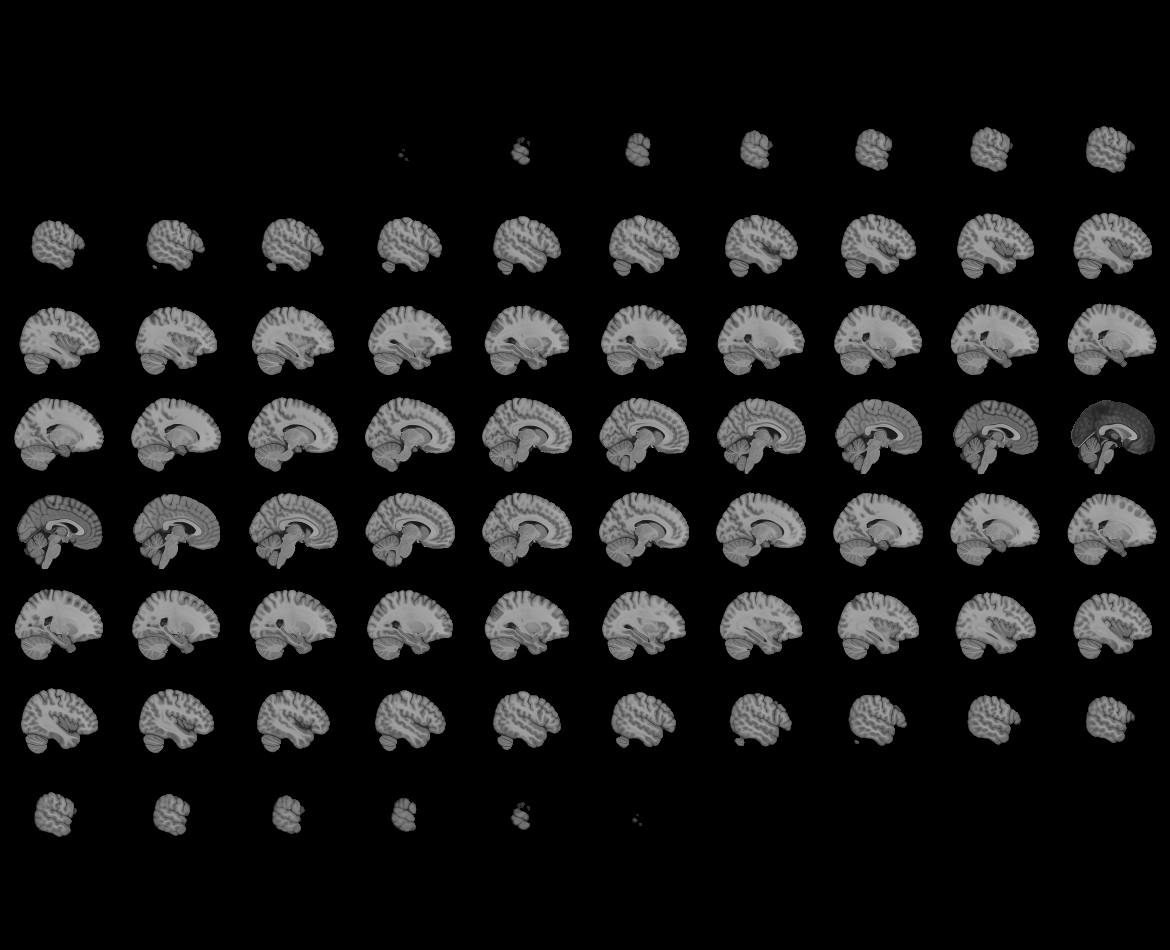
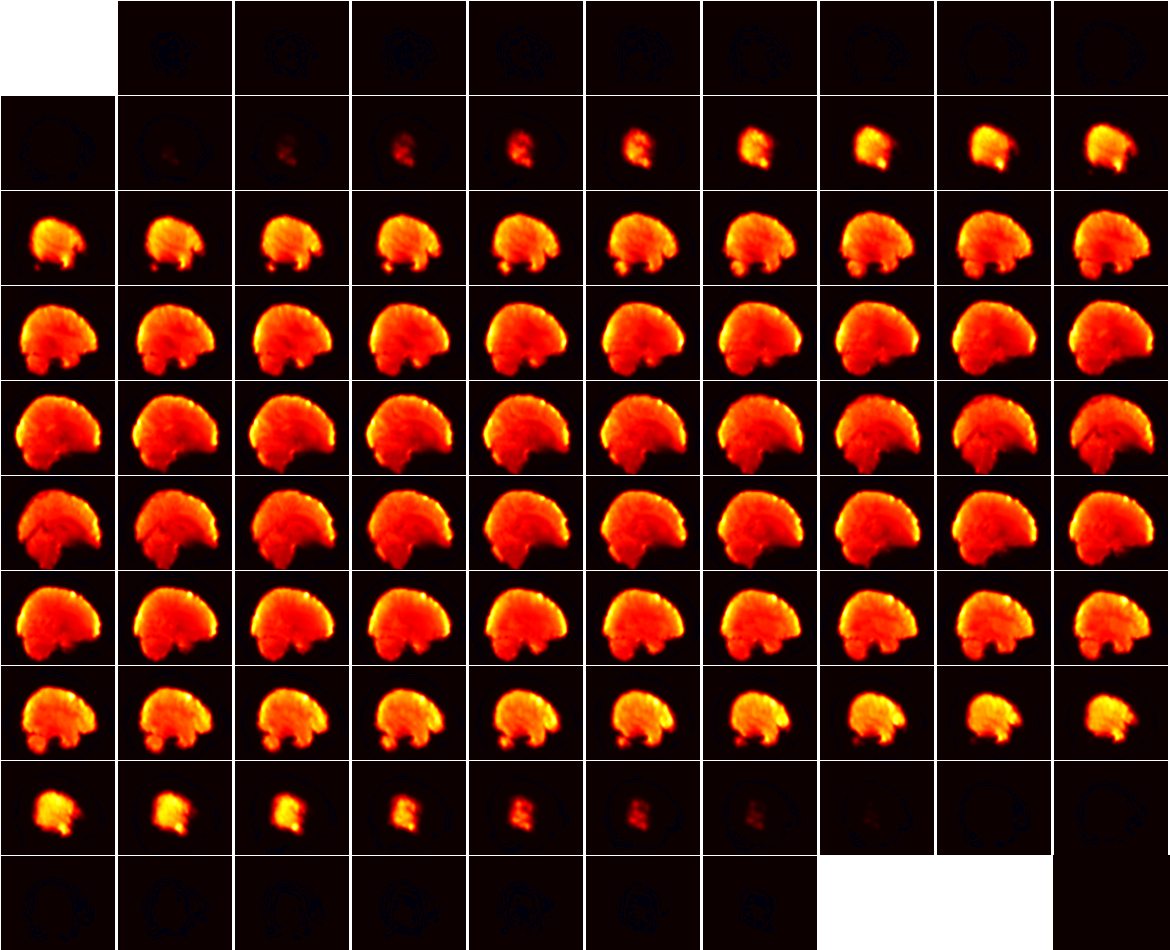

In [59]:
plotting.view_img(mean_img(andrew_brain_filename), threshold=None)

In [74]:
data = andrew_brain_img.get_fdata()
nifti_img = nib.load(andrew_brain_filename)

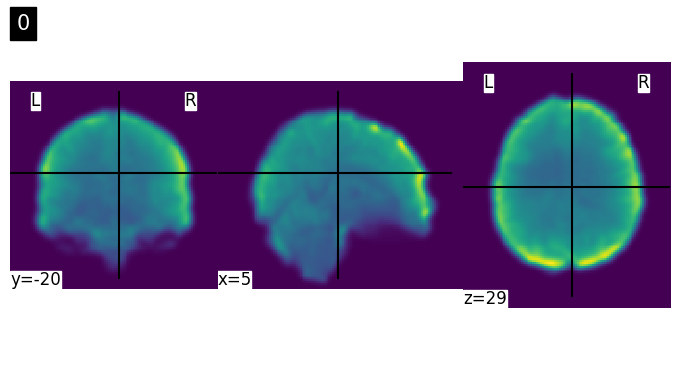

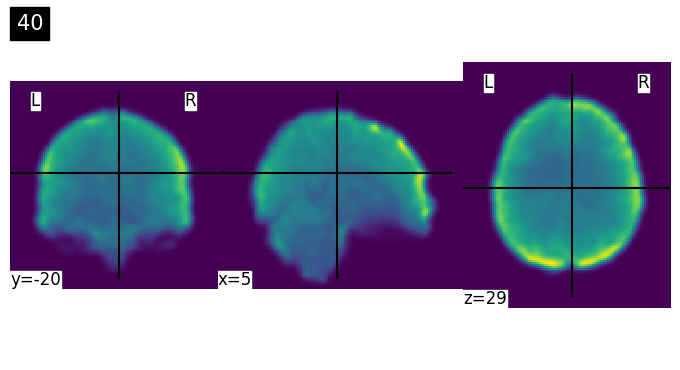

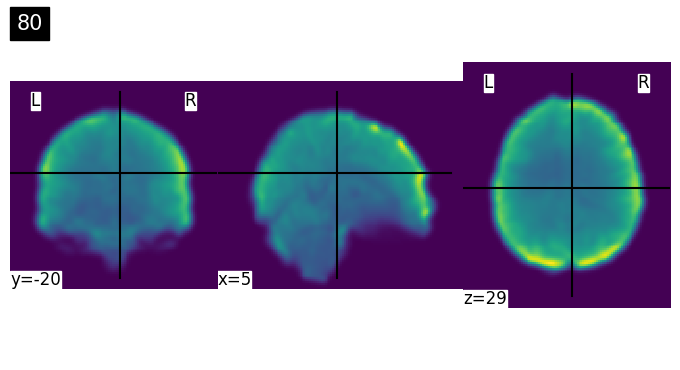

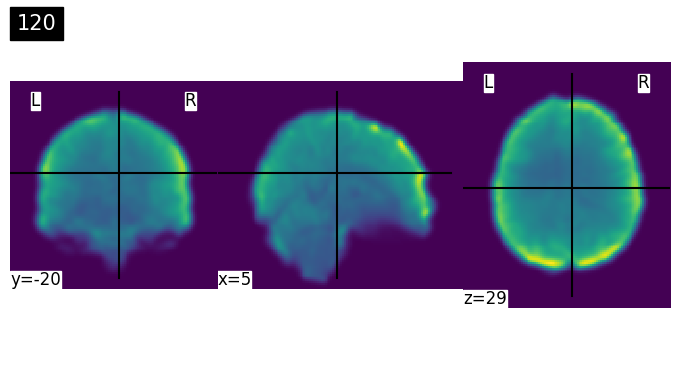

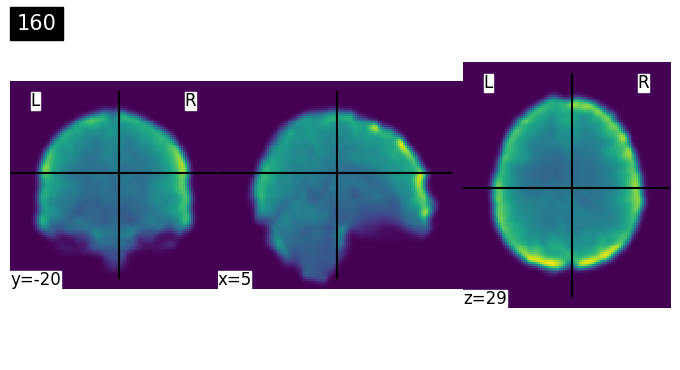

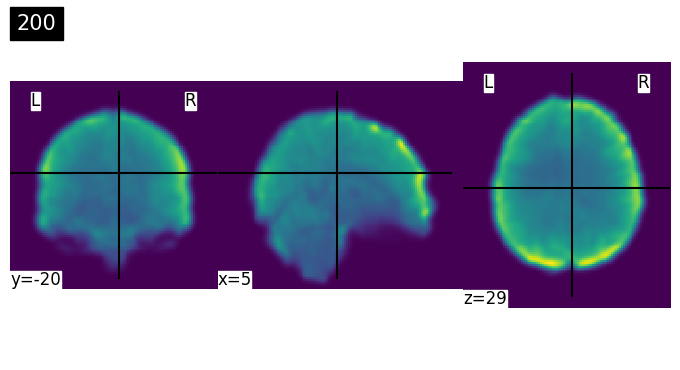

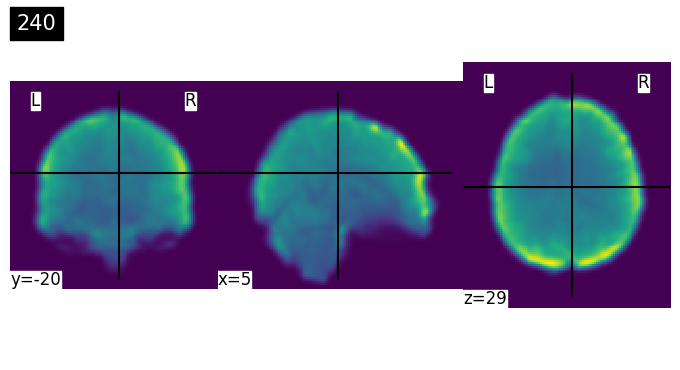

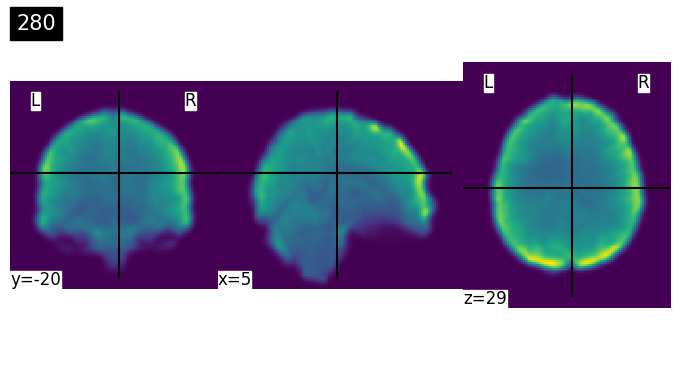

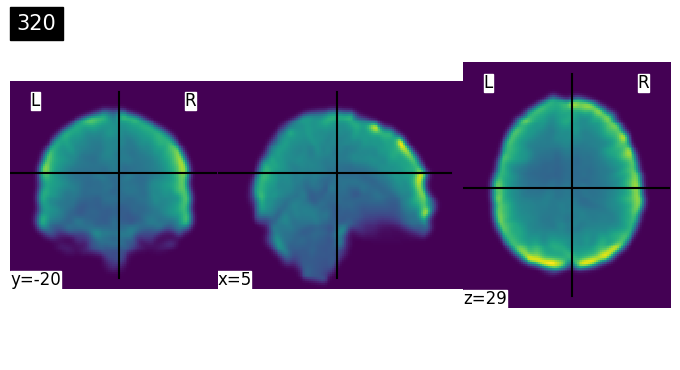

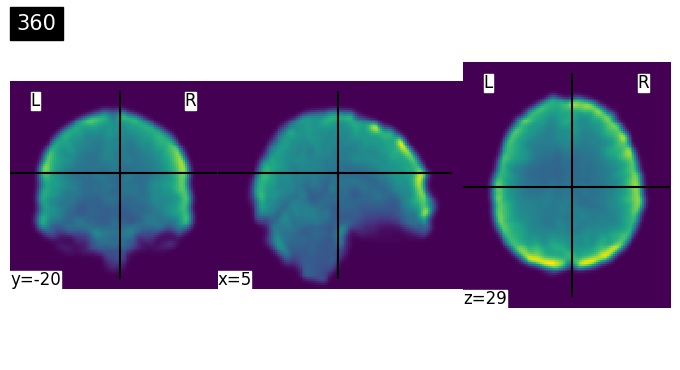

In [80]:
for i in range(data.shape[3]):
    if i%40 == 0:
        volume = data[:,:,:,i]
        volume_img = nib.Nifti1Image(volume, affine=nifti_img.affine)
        plotting.plot_img(volume_img, threshold=None, title=f"{i}")